In [2]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966 (90 deg)
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0 (0 deg)
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793 (180 deg)
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse

def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean

def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

def vector_reject(u,v):
    #project u on v, subject u1 from u
    P = np.outer(v,(v.T))/(v@(v.T))
    u_sub = u - P@u
#     another calculation, to double-check
#     v_norm = np.sqrt(sum(v**2))    
#     proj_u_on_v = (np.dot(u, v)/v_norm**2)*v
#     u_sub = u - proj_u_on_v
    return u_sub

# Single Lag

In [37]:
dataset_5ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_5ms.resample(5)
dataset_5ms.smooth_spk(40, name='smth_40')
bin_width = dataset_5ms.bin_width
print(bin_width)

5


In [38]:
n_dims = 20 # for PCA

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
n_trials = dataset_5ms.trial_info.loc[active_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

#make dictionary for trial condition (reaching directions) for Stratified CV
active_trials_idx = np.array(dataset_5ms.trial_info.loc[active_mask]['trial_id'])
cond_dir_idx = []
cond_dict = nans([n_trials])
for direction in [0,45,90,135,180,225,270,315]:
    cond_dir_idx.append(np.where((dataset_5ms.trial_info['cond_dir'] == direction) & (dataset_5ms.trial_info['ctr_hold_bump'] == False) & \
           (dataset_5ms.trial_info['split'] != 'none'))[0])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(cond_dir_idx)):
        if idx in cond_dir_idx[cond]:
            cond_dict[i] = cond
            break
    i+=1
print(cond_dict)

193 trials
65 neurons
(444690, 65)
(444493, 65)
(444690, 20)
PCA total var explained: 0.4742076808283448
[1. 1. 6. 4. 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0.
 0. 0. 3. 7. 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4.
 3. 3. 6. 1. 0. 2. 0. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5.
 1. 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0.
 2. 5. 1. 3. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2. 2. 7. 0. 4.
 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2. 1. 5. 1. 1.
 1.]


In [15]:
def process_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:,:]
    X_test = X[test_set,:,:]
    y_train = y[training_set,:,:]
    y_test = y[test_set,:,:]

    #flat by trials
    X_flat_train = X_train.reshape((X_train.shape[0]*X_train.shape[1]),X_train.shape[2])
    X_flat_test = X_test.reshape((X_test.shape[0]*X_test.shape[1]),X_test.shape[2])
    y_train=y_train.reshape((y_train.shape[0]*y_train.shape[1]),y_train.shape[2])
    y_test=y_test.reshape((y_test.shape[0]*y_test.shape[1]),y_test.shape[2])
    
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)   
    #array with only NaNs will have 0 std and cause errors
    X_flat_train_std[X_flat_train_std==0] = 1
    
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    y_train_mean=np.mean(y_train,axis=0)
    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean    
    
    return X_flat_train,X_flat_test,y_train,y_test

In [101]:
def fit_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field, y_field):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]
    
    # stored by trials for train/test splitting
    rates_array = nans([n_trials,n_timepoints,n_neurons])
    vel_array = nans([n_trials,n_timepoints,2])
    i=0
    for idx, trial in rates_df.groupby('trial_id'):
        rates_array[i,:,:]=trial[x_field].to_numpy()
        i+=1    
    i=0
    for idx, trial in vel_df.groupby('trial_id'):
        vel_array[i,:,:]=trial[y_field].to_numpy()
        i+=1  
    
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
    rates_array_reshaped = rates_array.reshape((rates_array.shape[0]*rates_array.shape[1]),rates_array.shape[2])
    vel_array_reshaped = vel_array.reshape((vel_array.shape[0]*vel_array.shape[1]),vel_array.shape[2])
    lr_all.fit(rates_array_reshaped, vel_array_reshaped)
    
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
    true_concat = nans([n_trials*n_timepoints,2])
    pred_concat = nans([n_trials*n_timepoints,2])
    trial_save_idx = 0
    for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        
        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2, lr_all.best_estimator_.coef_

In [103]:
def get_R2_reject(dataset, trial_mask, align_field, align_range, lag, x_field, y_field, sub_weights):
    
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]
    
    # stored by trials for train/test splitting
    rates_array = nans([n_trials,n_timepoints,n_neurons])
    vel_array = nans([n_trials,n_timepoints,2])
    i=0
    for idx, trial in rates_df.groupby('trial_id'):
        rates_array[i,:,:]=trial[x_field].to_numpy()
        i+=1    
    i=0
    for idx, trial in vel_df.groupby('trial_id'):
        vel_array[i,:,:]=trial[y_field].to_numpy()
        i+=1  
    
    rates_array_reshaped = rates_array.reshape((rates_array.shape[0]*rates_array.shape[1]),rates_array.shape[2])
    vel_array_reshaped = vel_array.reshape((vel_array.shape[0]*vel_array.shape[1]),vel_array.shape[2])
    
    true_concat = vel_array_reshaped
    pred_concat = nans([n_trials*n_timepoints,2])
    
    weight_x = sub_weights[0,:]
    weight_y = sub_weights[1,:]
    pred_concat[:,0] = np.dot(rates_array_reshaped,weight_x)
    pred_concat[:,1] = np.dot(rates_array_reshaped,weight_y)
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2

## with Neurons

In [91]:
lag_axis = np.arange(-300,300,20)
x_field = 'spikes_smth_40'
y_field ='hand_vel'
active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')

R2: 0.19225681145931584
R2: 0.2628796484522957
R2: 0.3361683187548955
R2: 0.40815959684098824
R2: 0.4751036247513182
R2: 0.5328932860619437
R2: 0.5777651170438067
R2: 0.6084940627817992
R2: 0.6268545458637618
R2: 0.6361839406029626
R2: 0.640526524975948
R2: 0.6438195788768978
R2: 0.6487276264075608
R2: 0.6565221152056904
R2: 0.6670162089195946
R2: 0.6781389279926286
R2: 0.6867942785492634
R2: 0.6905047731260625
R2: 0.6889065266059394
R2: 0.6836703834886252
R2: 0.6767225324040117
R2: 0.669344245675366
R2: 0.66177248799888
R2: 0.6528387582324966
R2: 0.6408984071540026
R2: 0.6244999592008535
R2: 0.6026912695969036
R2: 0.5761838821718901
R2: 0.5471983842595821
R2: 0.5176429570625425


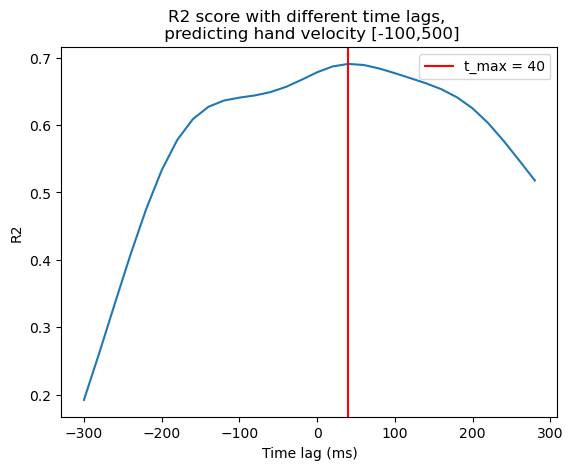

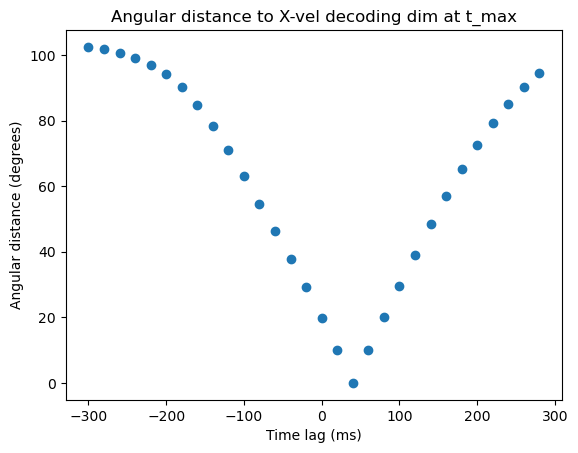

R2: 0.2048393732577639
R2: 0.2912459657567309
R2: 0.3822488866067455
R2: 0.46423250953539663
R2: 0.5256138373742492
R2: 0.5617598599387305
R2: 0.573856955080084
R2: 0.5644241008548997
R2: 0.5365927401456659
R2: 0.49535035067585664
R2: 0.44520422890762146
R2: 0.38810360716987513
R2: 0.3236903658673369
R2: 0.2502298278659303
R2: 0.1696976245107814
R2: 0.0912165283705012
R2: 0.029180263474246626
R2: -0.003714435809891503
R2: -0.0021770810361829707
R2: 0.03366625958189484
R2: 0.10018234562368089
R2: 0.18960603263525366
R2: 0.2907048198548653
R2: 0.3907107001673157
R2: 0.4768221265943544
R2: 0.5387117600407145
R2: 0.5716237430912561
R2: 0.5770436523852711
R2: 0.5613420506434512
R2: 0.533494033358799


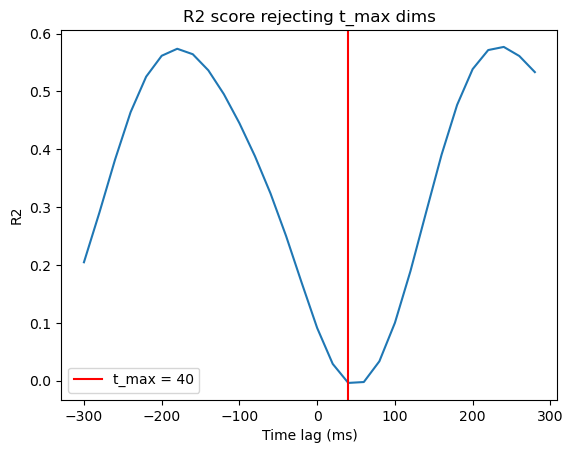

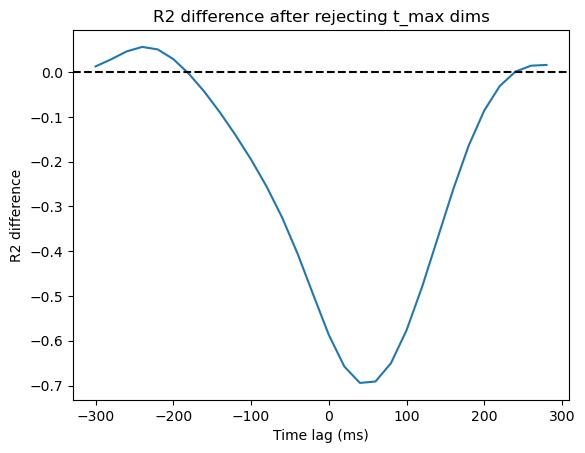

In [92]:
whole_r2_array = []
whole_coef_array = []
for lag in lag_axis:
    # Filter active or passive trials
    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (-100, 500), lag, x_field, y_field)
    whole_r2_array.append(r2)
    whole_coef_array.append(coef)

curr_r2_array = np.array(whole_r2_array)
curr_coef_array = np.array(whole_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [-100,500]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, active_mask, 'move_onset_time', (-100, 500), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: -0.4276468124982542
R2: -0.47715187031641015
R2: -0.5134009631043281
R2: -0.45571064995778277
R2: -0.2912440593061021
R2: -0.08982392239901293
R2: 0.10359740581061516
R2: 0.30708024861930194
R2: 0.48422031003345134
R2: 0.6010830045596705
R2: 0.66130582307556
R2: 0.684315412036044
R2: 0.6851699223577628
R2: 0.669914051122481
R2: 0.6435185751569671
R2: 0.6211796712482138
R2: 0.6285182146117947
R2: 0.6465969223014312
R2: 0.6637254777522463
R2: 0.6855008555536962
R2: 0.7033331171066641
R2: 0.7076425564952159
R2: 0.7020641255523217
R2: 0.7058408305604209
R2: 0.6999419893794057
R2: 0.681017038913735
R2: 0.6675743434434549
R2: 0.659530077926767
R2: 0.6474363431505126
R2: 0.6273838217304841


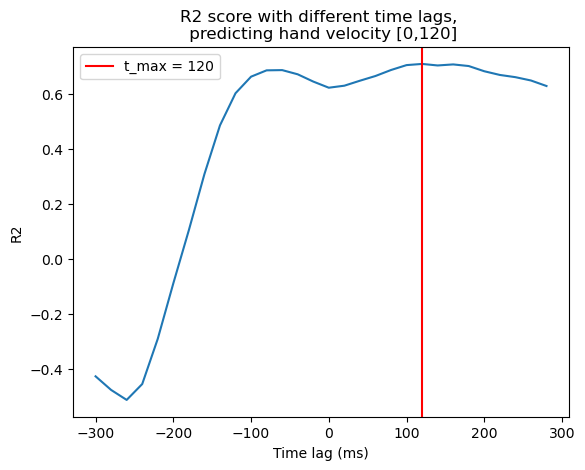

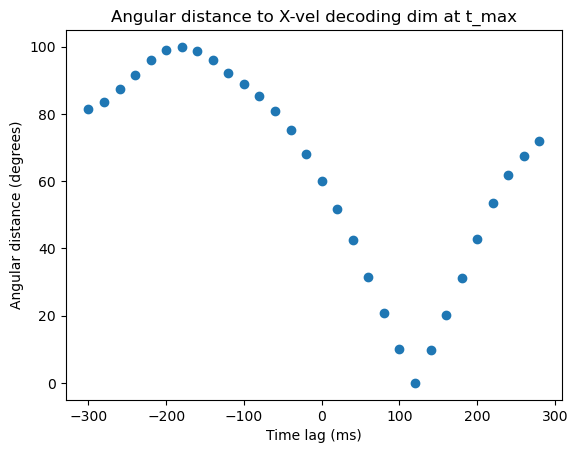

R2: -0.002763908670325721
R2: 0.028653672971505673
R2: 0.040937188146671244
R2: 0.03414491044999324
R2: 0.03157714071444406
R2: 0.09294455912870592
R2: 0.21444220022958504
R2: 0.3436383494014591
R2: 0.4714437661882812
R2: 0.5769902444867057
R2: 0.6199927601144488
R2: 0.5755161575211041
R2: 0.3846388088076045
R2: 0.041910144393774496
R2: -0.30912308162259805
R2: -0.5027177169069137
R2: -0.4738912932694834
R2: -0.267278053097737
R2: -0.03995452623145246
R2: 0.06753383709951233
R2: 0.03996947999370126
R2: -0.04356965137557656
R2: -0.0990869723602068
R2: -0.09550125736979775
R2: -0.0391835241550651
R2: 0.05997822780276052
R2: 0.1758447608299163
R2: 0.28702156590945505
R2: 0.3816327648970578
R2: 0.4520212674866909


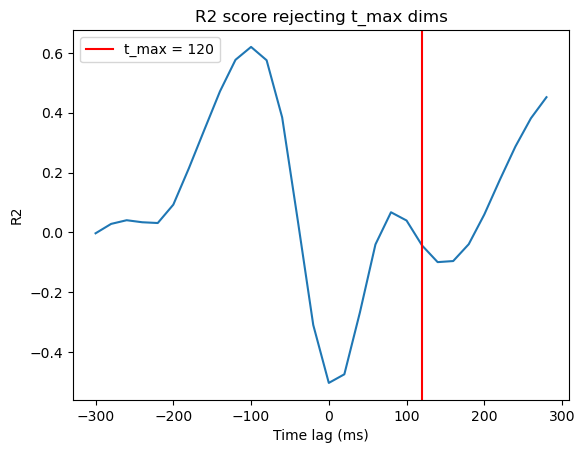

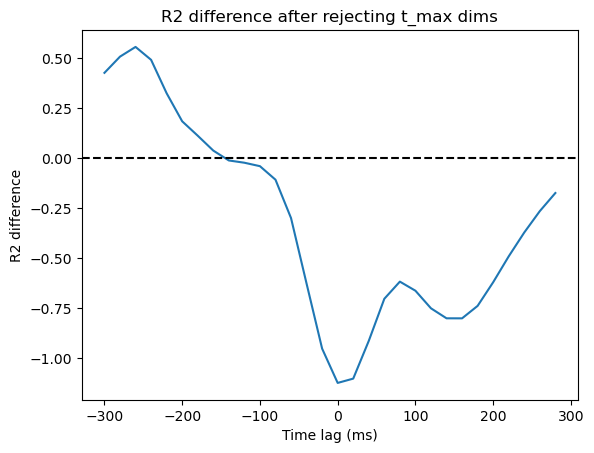

In [93]:
early_r2_array = []
early_coef_array = []
for lag in lag_axis:
    # Filter active or passive trials
    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (0, 120), lag, x_field, y_field)
    early_r2_array.append(r2)
    early_coef_array.append(coef)

curr_r2_array = np.array(early_r2_array)
curr_coef_array = np.array(early_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [0,120]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, active_mask, 'move_onset_time', (0, 120), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: 0.44967943011827227
R2: 0.55119374051246
R2: 0.6188077843209716
R2: 0.668871920015113
R2: 0.698420454902489
R2: 0.7148920138886619
R2: 0.721325421572123
R2: 0.7259913625160601
R2: 0.7245453003610987
R2: 0.7255515896009948
R2: 0.7310934711474785
R2: 0.7433813596561061
R2: 0.7548014091954032
R2: 0.7660523855628628
R2: 0.7751199714726014
R2: 0.7887277265280522
R2: 0.8012161806219509
R2: 0.8033342022714172
R2: 0.780294198153762
R2: 0.7799349447992511
R2: 0.7960356219507518
R2: 0.7951126661683185
R2: 0.784638257905931
R2: 0.7735370649305163
R2: 0.7587055788746409
R2: 0.7349458231576709
R2: 0.7053825253136503
R2: 0.6734020316115501
R2: 0.644991144599067
R2: 0.6328783598534747


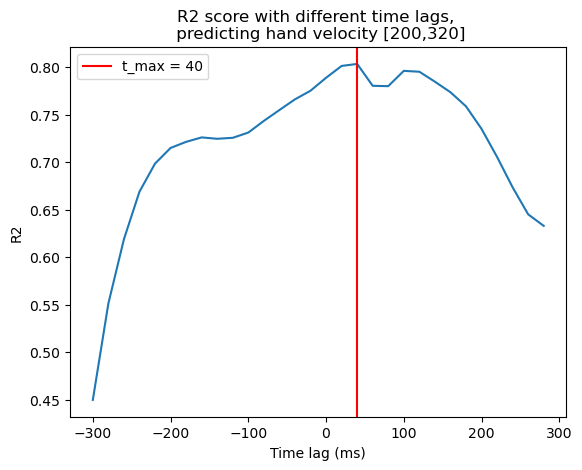

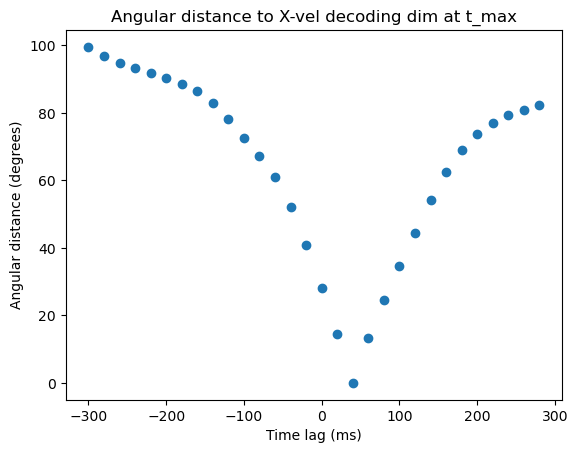

R2: 0.61227277829699
R2: 0.6930635289179123
R2: 0.7480816529701665
R2: 0.7843016103013114
R2: 0.8008588856587628
R2: 0.7836352456273299
R2: 0.7289829164564752
R2: 0.6537167530410596
R2: 0.5853329872159674
R2: 0.5363350325006968
R2: 0.49468875588530326
R2: 0.4588456612665148
R2: 0.4408768731943
R2: 0.41042514910297734
R2: 0.31700974450507247
R2: 0.17175620459375673
R2: 0.04206612181048408
R2: -0.002402998169882764
R2: 0.056929630576138535
R2: 0.18569360347742947
R2: 0.3388089962684664
R2: 0.48408776388063657
R2: 0.5984516467040402
R2: 0.6693713301007138
R2: 0.7105992050020098
R2: 0.7483898577084083
R2: 0.7788060694709799
R2: 0.7839195128589475
R2: 0.7684417467511049
R2: 0.7500709142384636


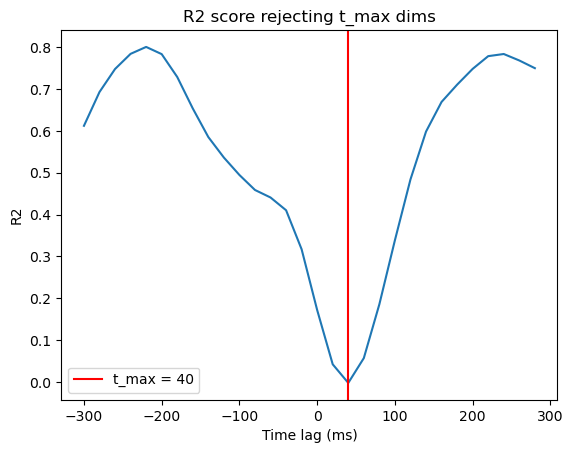

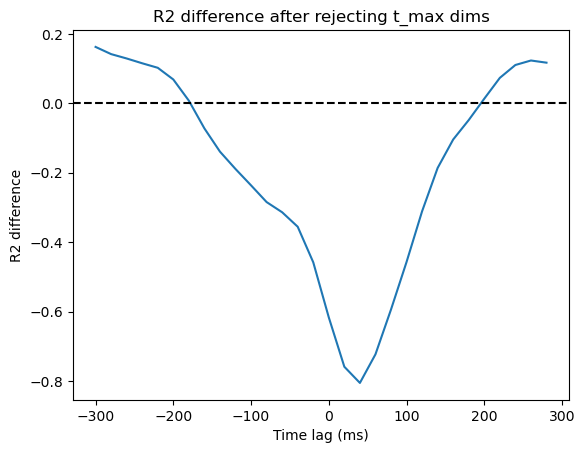

In [94]:
mid_r2_array = []
mid_coef_array = []
for lag in lag_axis:
    # Filter active or passive trials
    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (200, 320), lag, x_field, y_field)
    mid_r2_array.append(r2)
    mid_coef_array.append(coef)

curr_r2_array = np.array(mid_r2_array)
curr_coef_array = np.array(mid_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [200,320]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, active_mask, 'move_onset_time', (200, 320), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: 0.14205067439376484
R2: 0.1422345133676236
R2: 0.1722405047866109
R2: 0.24462432699785142
R2: 0.32009648384607503
R2: 0.359843000109499
R2: 0.39222432279325725
R2: 0.41362150055756
R2: 0.43141197295695843
R2: 0.28752524274986235
R2: 0.4221450276404549
R2: 0.524084594657941
R2: 0.5428973490321057
R2: 0.5560955378868049
R2: 0.5632796086721554
R2: 0.5781942281120216
R2: 0.601694781112128
R2: 0.6062397213116523
R2: 0.5775761739986782
R2: 0.525640347730326
R2: 0.4693446241498431
R2: 0.4371214316095239
R2: 0.4130135771586788
R2: 0.38157238179772557
R2: 0.3354188147793029
R2: -0.3823797670658955
R2: -0.14494305772258342
R2: 0.007272664846310506
R2: 0.06430700051928995
R2: 0.02422554899173568


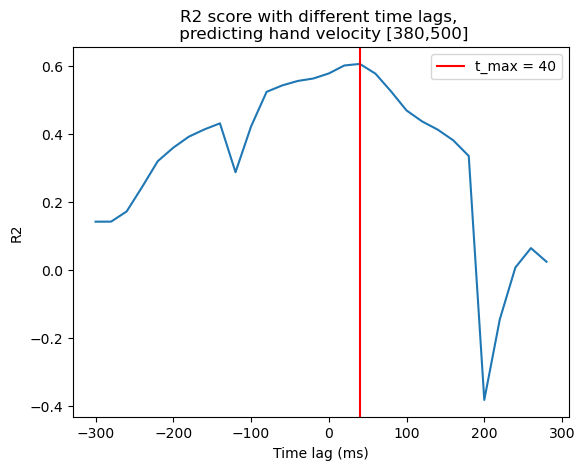

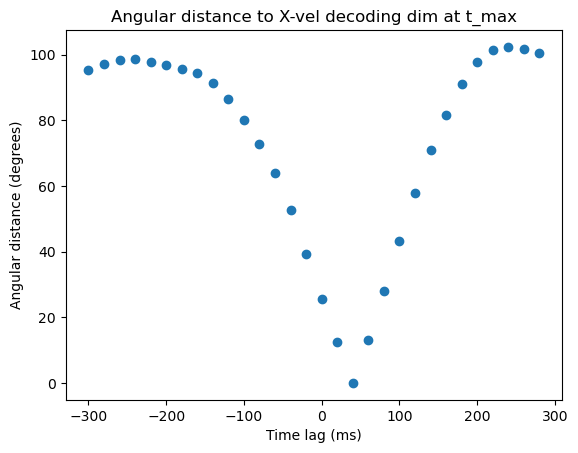

R2: -0.6374584421577205
R2: -0.2927606909338363
R2: 0.06118845286336927
R2: 0.2498461954818172
R2: 0.2872441939570911
R2: 0.29918987546810816
R2: 0.34868726805581396
R2: 0.4285777828664975
R2: 0.5113776179693978
R2: 0.5680232628379799
R2: 0.5597814778964999
R2: 0.4740195013611286
R2: 0.36204229612700467
R2: 0.2550220337811838
R2: 0.12087760724435281
R2: -0.04641799281538961
R2: -0.1844461586831494
R2: -0.2156977446780446
R2: -0.10137441392581059
R2: 0.11410875747544347
R2: 0.32392505964740226
R2: 0.46211344703077684
R2: 0.5227609546086334
R2: 0.4852108110556238
R2: 0.30603811108937884
R2: 0.032403247080180386
R2: -0.2001340256248012
R2: -0.3078186263426408
R2: -0.2500420139757793
R2: -0.055626115891512784


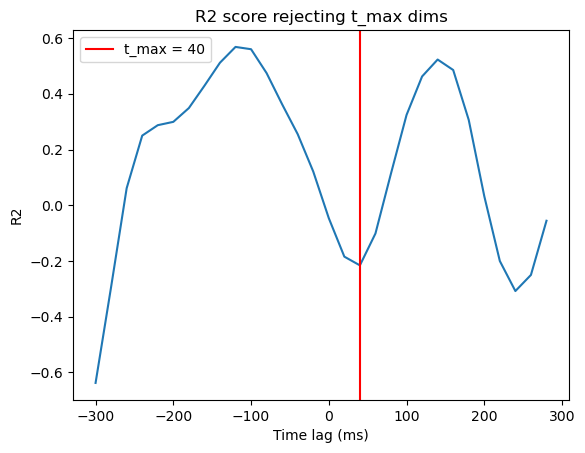

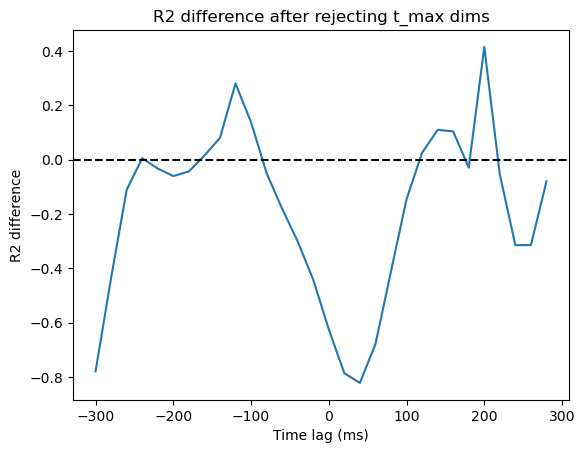

In [95]:
late_r2_array = []
late_coef_array = []
for lag in lag_axis:
    # Filter active or passive trials
    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (380, 500), lag, x_field, y_field)
    late_r2_array.append(r2)
    late_coef_array.append(coef)

curr_r2_array = np.array(late_r2_array)
curr_coef_array = np.array(late_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [380,500]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, active_mask, 'move_onset_time', (380, 500), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



## with PCA

In [96]:
x_field = 'PCA'
y_field ='hand_vel'
lag_axis = np.arange(-300,300,20)
active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')

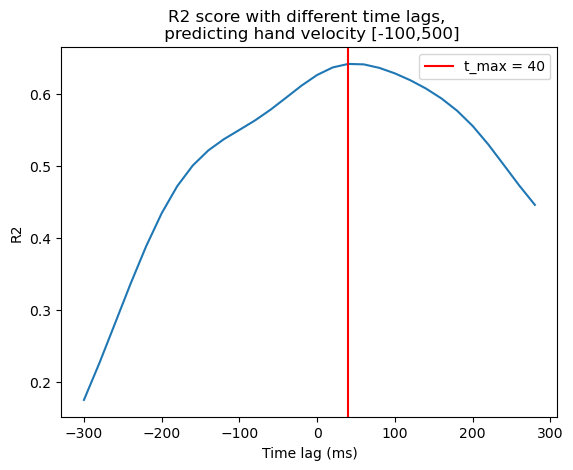

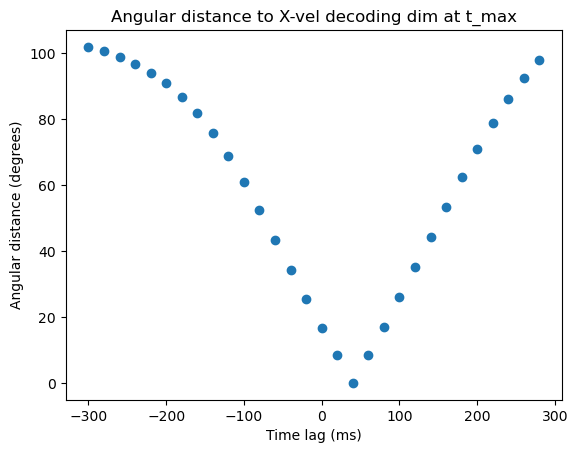

R2: 0.1869942591455549
R2: 0.2374263118652331
R2: 0.29227172222296616
R2: 0.34780543962722943
R2: 0.3997007893382376
R2: 0.44320346768341434
R2: 0.47342213733956484
R2: 0.48600246013060233
R2: 0.4778360769357397
R2: 0.44750725390985224
R2: 0.39579691039859655
R2: 0.3261964017142188
R2: 0.2448607229081332
R2: 0.16056085956696142
R2: 0.08412230266628651
R2: 0.026274808267430894
R2: -0.004584268281652815
R2: -0.003714435809891503
R2: 0.02804482958498211
R2: 0.08495563244650983
R2: 0.15975305510854265
R2: 0.24448833849204898
R2: 0.329546831027016
R2: 0.40482816410648337
R2: 0.46229429057884563
R2: 0.4972369466151444
R2: 0.5089500772814882
R2: 0.5010626137070243
R2: 0.47993030059213027
R2: 0.4519621041125367


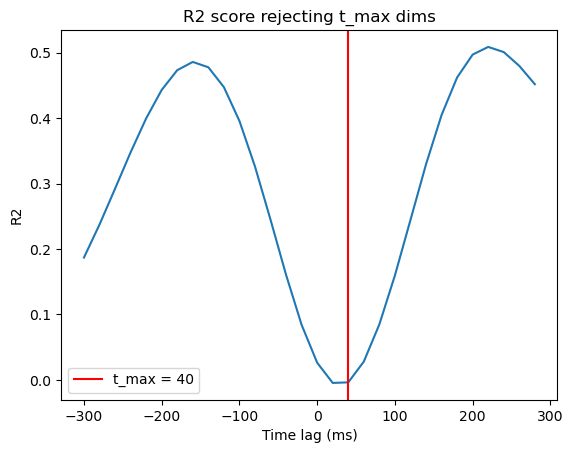

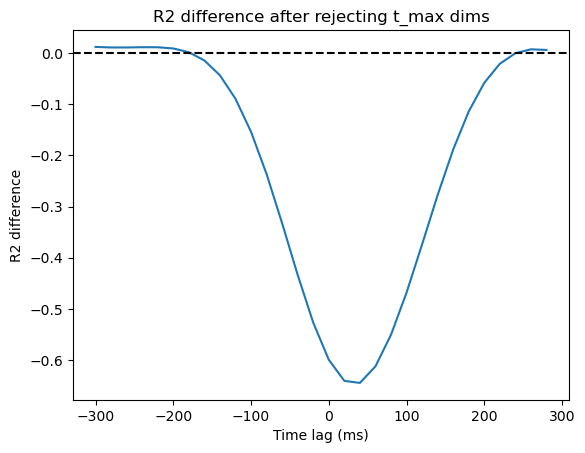

In [104]:
PCA_whole_r2_array = []
PCA_whole_coef_array = []
for lag in lag_axis:
    # Filter active or passive trials
    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (-100, 500), lag, x_field, y_field)
    PCA_whole_r2_array.append(r2)
    PCA_whole_coef_array.append(coef)

curr_r2_array = np.array(PCA_whole_r2_array)
curr_coef_array = np.array(PCA_whole_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [-100,500]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, active_mask, 'move_onset_time', (-100, 500), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: -0.11237953352866081
R2: -0.10846452458809064
R2: -0.10957800691279185
R2: -0.10586565238730983
R2: -0.07536250735637773
R2: 0.005931035915922922
R2: 0.1383416847743527
R2: 0.29159710650554094
R2: 0.43112191177455916
R2: 0.5359140342857978
R2: 0.5981553897588037
R2: 0.6232070059659599
R2: 0.626832184967195
R2: 0.6243255589737902
R2: 0.6240219713653372
R2: 0.6264690662731984
R2: 0.6285565230351065
R2: 0.6335319208015233
R2: 0.6451087730193246
R2: 0.6620191503893759
R2: 0.6806539568075735
R2: 0.6954585051399287
R2: 0.7029240350884085
R2: 0.7026889941804779
R2: 0.6945479153637638
R2: 0.6797715678678247
R2: 0.662634407408726
R2: 0.6472485181133366
R2: 0.6348760692676382
R2: 0.6224608128346477


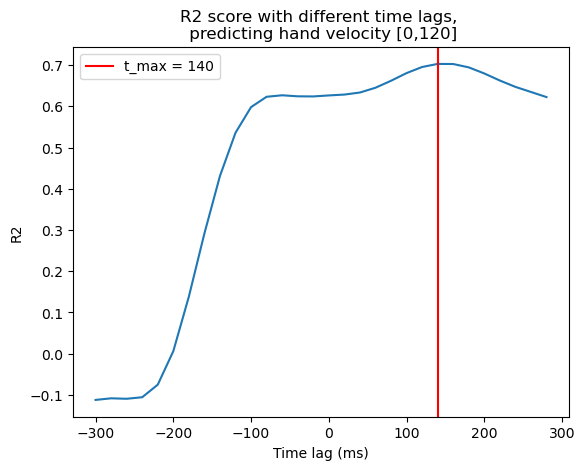

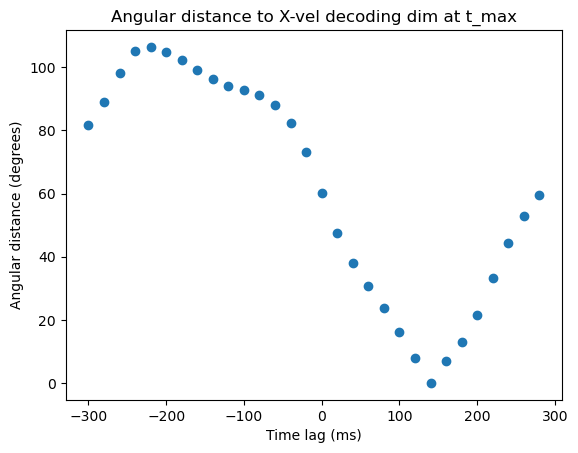

R2: -0.007590874097333389
R2: -0.0034555559215136977
R2: 2.1430158892887796e-05
R2: 0.010746054612860378
R2: 0.04533710112223299
R2: 0.1178362849206177
R2: 0.2326970959490483
R2: 0.37152282303451956
R2: 0.4990625687729867
R2: 0.5945501223610272
R2: 0.6535948911710086
R2: 0.6760036796492781
R2: 0.6655080493024093
R2: 0.6282714415600631
R2: 0.5750390059035854
R2: 0.5281949976047351
R2: 0.49318678875099664
R2: 0.4436189641752434
R2: 0.35775007871313336
R2: 0.24448428382569853
R2: 0.1306541270971825
R2: 0.03208722583498003
R2: -0.04356965137557656
R2: -0.0781795823485214
R2: -0.05829491342258564
R2: -0.001996059154845131
R2: 0.057891986645592586
R2: 0.11045496430134472
R2: 0.16577231025474193
R2: 0.2266770866803236


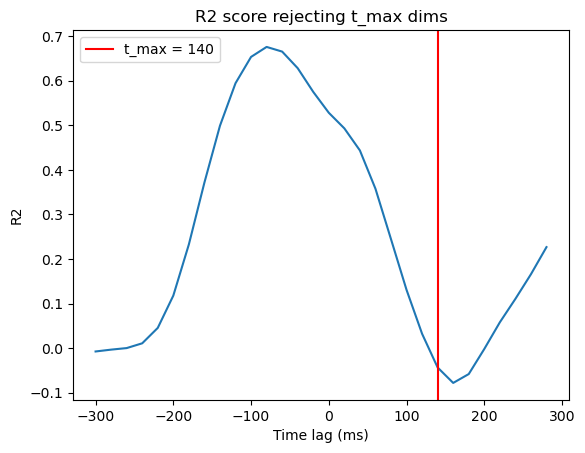

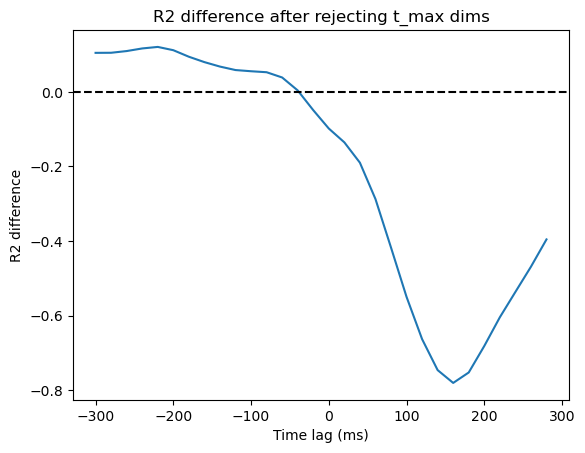

In [105]:
PCA_early_r2_array = []
PCA_early_coef_array = []
for lag in lag_axis:
    # Filter active or passive trials
    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (0, 120), lag, x_field, y_field)
    PCA_early_r2_array.append(r2)
    PCA_early_coef_array.append(coef)

curr_r2_array = np.array(PCA_early_r2_array)
curr_coef_array = np.array(PCA_early_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [0,120]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, active_mask, 'move_onset_time', (0, 120), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: 0.43171838040493826
R2: 0.5208280436450958
R2: 0.5845136298519904
R2: 0.6260966519053058
R2: 0.6503032216124827
R2: 0.6581240177375953
R2: 0.6544124655676754
R2: 0.6510157141356203
R2: 0.6564533705664126
R2: 0.6727072017284248
R2: 0.6978711629590937
R2: 0.7251293159087917
R2: 0.7465061370597426
R2: 0.7595669520846388
R2: 0.7675305287725271
R2: 0.7726717371972491
R2: 0.7753905586248083
R2: 0.7766754279908954
R2: 0.7768697495286742
R2: 0.7747525185863922
R2: 0.7695829267891336
R2: 0.7621760192394974
R2: 0.7530399673114658
R2: 0.7415482254517447
R2: 0.7267150051319392
R2: 0.7074278306125674
R2: 0.6863250236835527
R2: 0.6690386800531634
R2: 0.6568293946524622
R2: 0.6459586366561829


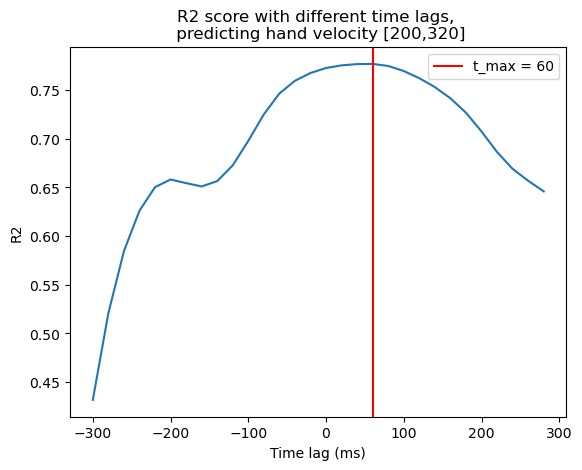

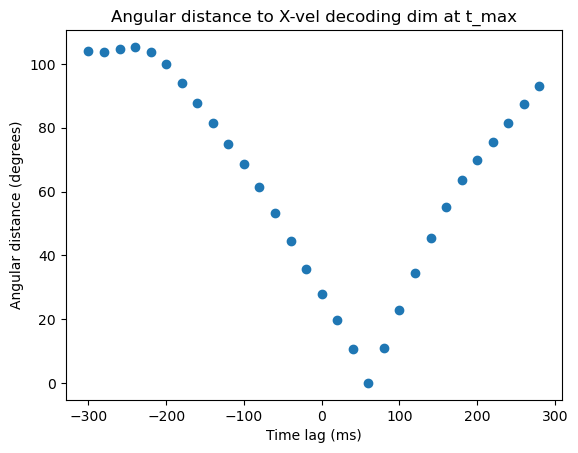

R2: 0.42374680941040177
R2: 0.5204648892253174
R2: 0.5897699417784188
R2: 0.6316934183560203
R2: 0.6492798359805617
R2: 0.6482840475786349
R2: 0.6344474749445828
R2: 0.6123173521840262
R2: 0.5855874287823415
R2: 0.5512224357823681
R2: 0.5101606302684547
R2: 0.45978563629802804
R2: 0.39397243455348485
R2: 0.31656075748778334
R2: 0.23158428708730927
R2: 0.14222429240075374
R2: 0.06332260593763495
R2: 0.011988166968331715
R2: -0.002402998169883208
R2: 0.031611193144909455
R2: 0.1158360606132337
R2: 0.23051477419154676
R2: 0.3512942248872749
R2: 0.4583363520893142
R2: 0.540389265022932
R2: 0.5962900737611779
R2: 0.6300343209646688
R2: 0.6483149143075091
R2: 0.6580889554901852
R2: 0.6614088727445155


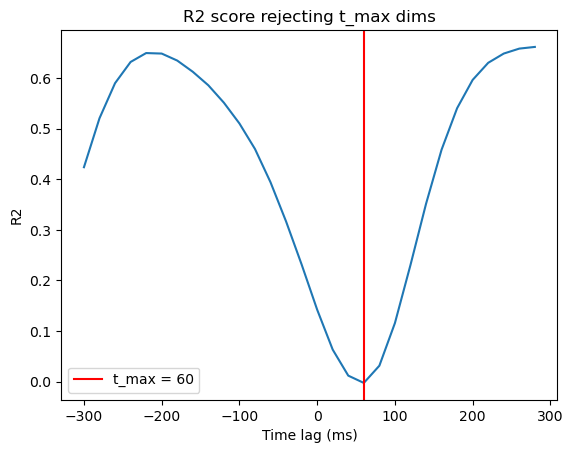

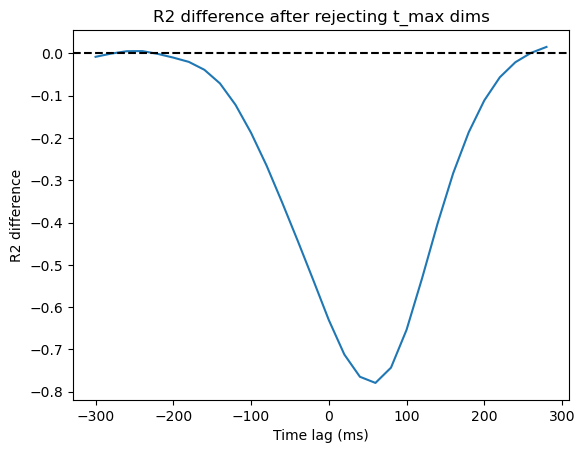

In [106]:
PCA_mid_r2_array = []
PCA_mid_coef_array = []
for lag in lag_axis:
    # Filter active or passive trials
    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (200, 320), lag, x_field, y_field)
    PCA_mid_r2_array.append(r2)
    PCA_mid_coef_array.append(coef)

curr_r2_array = np.array(PCA_mid_r2_array)
curr_coef_array = np.array(PCA_mid_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [200,320]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, active_mask, 'move_onset_time', (200, 320), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



R2: 0.24586784301096376
R2: 0.25522654860358107
R2: 0.2717788924032356
R2: 0.3008235771964347
R2: 0.33855677021049413
R2: 0.37742936326743015
R2: 0.4158076901277358
R2: 0.451725999857438
R2: 0.4773144914883112
R2: 0.4936037968359094
R2: 0.5096532011270682
R2: 0.5318587805958657
R2: 0.5620015989410805
R2: 0.5960700608787308
R2: 0.6258525105589322
R2: 0.642382041691397
R2: 0.637716943691923
R2: 0.6096719404682003
R2: 0.5653897805998658
R2: 0.5147351959360169
R2: 0.46177264406114704
R2: 0.4113958427758091
R2: 0.3682714693718576
R2: 0.3287900695825553
R2: 0.2925284932554383
R2: 0.26028871754446437
R2: 0.2315889733482308
R2: 0.20792205754678816
R2: 0.1905624133345507
R2: 0.17761937732650113


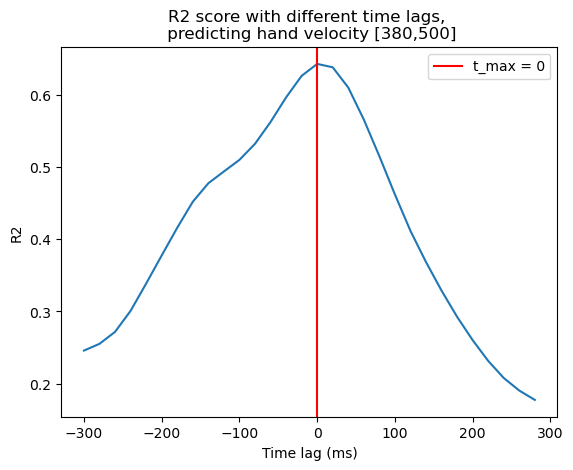

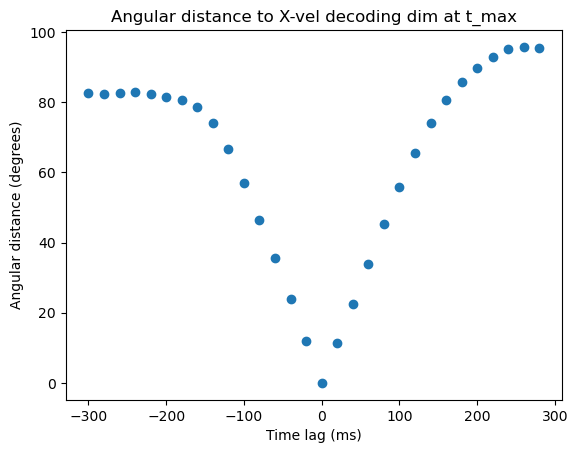

R2: 0.2923450397947579
R2: 0.29920950636718013
R2: 0.30087726010136184
R2: 0.29846523322559804
R2: 0.27221513372956585
R2: 0.20724947420103434
R2: 0.1388330344977161
R2: 0.12802745033573593
R2: 0.1831148764674455
R2: 0.24196118072295836
R2: 0.23324114172255683
R2: 0.14777634071099455
R2: 0.02090712268143491
R2: -0.10728969814148748
R2: -0.1971345995874645
R2: -0.2156977446780446
R2: -0.14554291968432476
R2: -0.005465492711374642
R2: 0.14934007899346957
R2: 0.26992265225331646
R2: 0.33826110879211957
R2: 0.36163793416197765
R2: 0.3590015654891403
R2: 0.34138919615376084
R2: 0.30831086932911833
R2: 0.26576414047433683
R2: 0.22932690682663082
R2: 0.21070492161618193
R2: 0.20854441966071657
R2: 0.20690170958322684


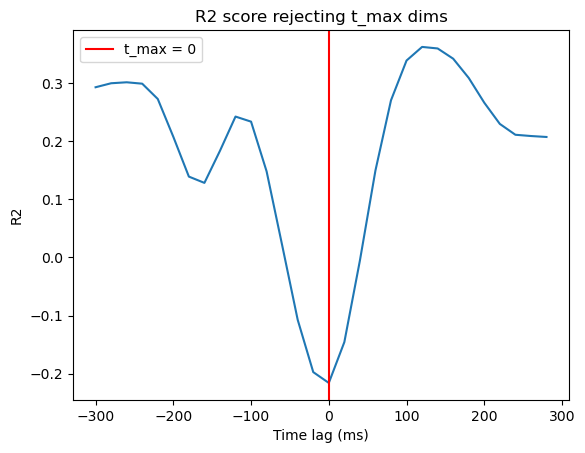

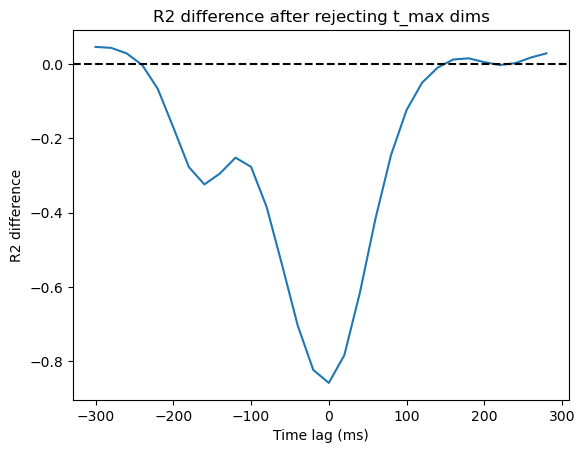

In [107]:
PCA_late_r2_array = []
PCA_late_coef_array = []
for lag in lag_axis:
    # Filter active or passive trials
    
    # Train decoders and predict velocity
    r2, coef = fit_and_predict(dataset_5ms, active_mask, 'move_onset_time', (380, 500), lag, x_field, y_field)
    PCA_late_r2_array.append(r2)
    PCA_late_coef_array.append(coef)

curr_r2_array = np.array(PCA_late_r2_array)
curr_coef_array = np.array(PCA_late_coef_array)
    
idx_max = np.argmax(curr_r2_array)
time_max = lag_axis[idx_max]

plt.plot(lag_axis, curr_r2_array)
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.title('R2 score with different time lags, \n predicting hand velocity [380,500]')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

ang_dist_to_max = nans([len(lag_axis)])
for i in range(0, len(curr_coef_array)):
    ang_dist_to_max[i] = math.degrees(angle_between(curr_coef_array[i,0,:],curr_coef_array[idx_max,0,:]))
plt.scatter(lag_axis, ang_dist_to_max)
plt.title('Angular distance to X-vel decoding dim at t_max')
plt.xlabel('Time lag (ms)')
plt.ylabel('Angular distance (degrees)')
plt.show()


#Reject decoding dimensions at time with max R2
sub_coef_array = nans([len(lag_axis),2,curr_coef_array.shape[2]])
sub_r2_array = nans([len(lag_axis)])
for i in range(len(lag_axis)):
    v = curr_coef_array[idx_max,:,:]
    u = curr_coef_array[i,:,:]
    sub_coef_array[i,:,:] = np.array([vector_reject(u[0],v[0]),vector_reject(u[1],v[1])])
    weights = sub_coef_array[i,:,:]
    lag = lag_axis[i]
    r2 = get_R2_reject(dataset_5ms, active_mask, 'move_onset_time', (380, 500), lag,x_field,y_field, weights)
    sub_r2_array[i] = r2
    

plt.plot(lag_axis,sub_r2_array)
plt.title('R2 score rejecting t_max dims')
plt.axvline(time_max, color = 'r', label='t_max = ' + str(time_max))
plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.show()

plt.plot(lag_axis,np.subtract(sub_r2_array,curr_r2_array))
plt.axhline(0,color = 'k',linestyle='--')
plt.title('R2 difference after rejecting t_max dims')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2 difference')
plt.show()



# Multi Lags

In [3]:
dataset_50ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_50ms.resample(50)
print(dataset_50ms.bin_width)

50


In [36]:
n_dims = 20 # for PCA

active_mask = (~dataset_50ms.trial_info.ctr_hold_bump) & (dataset_50ms.trial_info.split != 'none')
n_trials = dataset_50ms.trial_info.loc[active_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_50ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_50ms.data.spikes)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_50ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

193 trials
65 neurons
(44469, 65)
(44465, 65)
(44469, 20)
PCA total var explained: 0.40167740661436035


In [31]:
active_data = dataset_50ms.make_trial_data(align_field='move_onset_time', align_range=(-300, 700), ignored_trials=~active_mask)
for idx, trial in active_data.groupby('trial_id'):
    n_timepoints = trial.shape[0]
    break
print(n_timepoints,'time bins')

active_trials_neuron = nans([n_trials,n_timepoints,n_neurons])
active_trials_vel = nans([n_trials,n_timepoints,2])
active_trials_pca = nans([n_trials,n_timepoints,n_dims])
i = 0
for idx, trial in active_data.groupby('trial_id'):
    active_trials_neuron[i,:,:]=trial.spikes.to_numpy()
    active_trials_vel[i,:,:]=trial.hand_vel.to_numpy()
    active_trials_pca[i,:,:]=trial.PCA.to_numpy()
    i+=1
print(active_trials_neuron.shape)
print(active_trials_vel.shape)
print(active_trials_pca.shape)

#make dictionary for trial condition (reaching directions) for Stratified CV
active_trials_idx = np.array(dataset_50ms.trial_info.loc[active_mask]['trial_id'])
cond_dir_idx = []
cond_dict = nans([n_trials])
for direction in [0,45,90,135,180,225,270,315]:
    cond_dir_idx.append(np.where((dataset_50ms.trial_info['cond_dir'] == direction) & (dataset_50ms.trial_info['ctr_hold_bump'] == False) & \
           (dataset_50ms.trial_info['split'] != 'none'))[0])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(cond_dir_idx)):
        if idx in cond_dir_idx[cond]:
            cond_dict[i] = cond
            break
    i+=1
print(cond_dict)

20 time bins
(193, 20, 65)
(193, 20, 2)
(193, 20, 20)
[1. 1. 6. 4. 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0.
 0. 0. 3. 7. 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4.
 3. 3. 6. 1. 0. 2. 0. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5.
 1. 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0.
 2. 5. 1. 3. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2. 2. 7. 0. 4.
 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2. 1. 5. 1. 1.
 1.]


## with Neurons

In [28]:
data_range = [-300,700]
pred_start = -100
pred_end = 500

idx1 = int((pred_start - data_range[0])/dataset_50ms.bin_width)
idx2 = int(n_timepoints - (data_range[1]-pred_end)/dataset_50ms.bin_width)

t_before_range = range(0,201,50);
t_after_range = range(0,201,50);

whole_multi_R2s = nans([len(t_before_range),len(t_after_range)])
whole_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_neurons])
        i = 0
        for trial_data in active_trials_neuron:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = active_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        whole_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',whole_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    whole_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.5465052060939529
Predicting with 0 to 50 ms neural data
R2: 0.6632129748116127
Predicting with 0 to 100 ms neural data
R2: 0.7213058142160058
Predicting with 0 to 150 ms neural data
R2: 0.7522189219052917
Predicting with 0 to 200 ms neural data
R2: 0.7687846613697213
Predicting with -50 to 0 ms neural data
R2: 0.6526798853933211
Predicting with -50 to 50 ms neural data
R2: 0.7261716686133435
Predicting with -50 to 100 ms neural data
R2: 0.7668355022717351
Predicting with -50 to 150 ms neural data
R2: 0.7908438603550619
Predicting with -50 to 200 ms neural data
R2: 0.8019045551881492
Predicting with -100 to 0 ms neural data
R2: 0.7105799255518079
Predicting with -100 to 50 ms neural data
R2: 0.7647613603572552
Predicting with -100 to 100 ms neural data
R2: 0.7963210453680877
Predicting with -100 to 150 ms neural data
R2: 0.8138320419970406
Predicting with -100 to 200 ms neural data
R2: 0.8235230859531326
Predicting with -150 to 0 ms neural dat

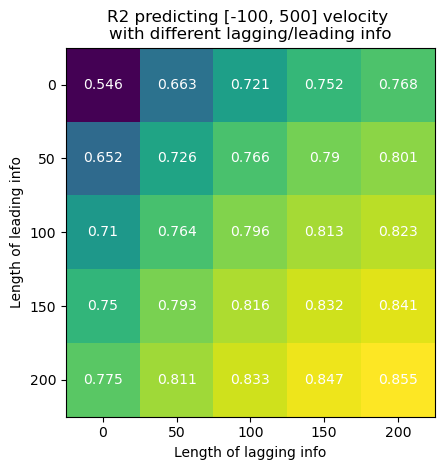

In [29]:
fig, ax = plt.subplots()
im = ax.imshow(whole_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [-100, 500] velocity \nwith different lagging/leading info")
fig.tight_layout()

for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(whole_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()

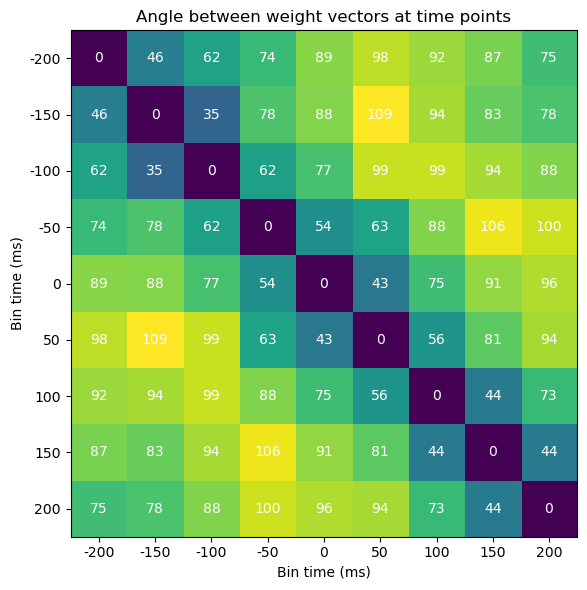

In [30]:
coef_X = whole_multi_coefs[-1][-1][0] #which entry's weights to use

t_label = np.arange(-200,201,50)

n_weights = len(t_before_range) + len(t_after_range) - 1
coef_X_reshaped = coef_X.reshape(n_weights,n_neurons)
angDist_array = nans([n_weights,n_weights])
for i in range(n_weights):
    for j in range(n_weights):
        angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(angDist_array)
ax.set_xlabel('Bin time (ms)')
ax.set_ylabel('Bin time (ms)')

ax.set_xticks(np.arange(len(t_label)))
ax.set_yticks(np.arange(len(t_label)))
ax.set_xticklabels(labels=t_label)
ax.set_yticklabels(labels=t_label)

ax.set_title("Angle between weight vectors at time points")
fig.tight_layout()

for i in range(len(t_label)):
    for j in range(len(t_label)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                       ha="center", va="center", color="w")
plt.show()


## with PCA

In [32]:
PCA_whole_multi_R2s = nans([len(t_before_range),len(t_after_range)])
PCA_whole_multi_coefs = []
j,k=0,0
for time_before in t_before_range:
    coef_arr = []
    for time_after in t_after_range:
        print('Predicting with',-time_before, 'to', time_after,'ms neural data')
        
        bins_before= int(time_before/dataset_50ms.bin_width) #How many bins of neural data prior to the output are used for decoding
        bins_current= 1 #Whether to use concurrent time bin of neural data
        bins_after= int(time_after/dataset_50ms.bin_width) #How many bins of neural data after the output are used for decoding

        n_total_bins = bins_before + bins_current + bins_after

        X =  nans([n_trials,idx2-idx1,n_total_bins*n_dims])
        i = 0
        for trial_data in active_trials_pca:
            trial_hist=get_spikes_with_history(trial_data,bins_before,bins_after,bins_current)
            trial_hist = trial_hist[idx1:idx2,:,:]
            trial_hist_flat=trial_hist.reshape(trial_hist.shape[0],(trial_hist.shape[1]*trial_hist.shape[2]))
            X[i,:,:] = trial_hist_flat
            i+=1
        
        y = active_trials_vel[:,idx1:idx2,:]
    
        lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
        X_reshaped = X.reshape((X.shape[0]*X.shape[1]),X.shape[2])
        y_reshaped = y.reshape((y.shape[0]*y.shape[1]),y.shape[2])
        lr_all.fit(X_reshaped, y_reshaped)

        
        skf = StratifiedKFold(n_splits=5,shuffle=True,random_state = 42)   
        true_concat = nans([(n_trials*(idx2-idx1)),2])
        pred_concat = nans([(n_trials*(idx2-idx1)),2])
        trial_save_idx = 0
        for training_set, test_set in skf.split(range(0,n_trials),cond_dict):
            #split training and testing by trials
            X_train, X_test, y_train, y_test = process_train_test(X,y,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n

        sses =get_sses_pred(true_concat,pred_concat)
        sses_mean=get_sses_mean(true_concat)
        PCA_whole_multi_R2s[j,k] =1-np.sum(sses)/np.sum(sses_mean)     
        print('R2:',whole_multi_R2s[j,k])
        coef_arr.append(lr_all.best_estimator_.coef_)
        k += 1
    j += 1
    k = 0
    PCA_whole_multi_coefs.append(coef_arr)

Predicting with 0 to 0 ms neural data
R2: 0.5465052060939529
Predicting with 0 to 50 ms neural data
R2: 0.6632129748116127
Predicting with 0 to 100 ms neural data
R2: 0.7213058142160058
Predicting with 0 to 150 ms neural data
R2: 0.7522189219052917
Predicting with 0 to 200 ms neural data
R2: 0.7687846613697213
Predicting with -50 to 0 ms neural data
R2: 0.6526798853933211
Predicting with -50 to 50 ms neural data
R2: 0.7261716686133435
Predicting with -50 to 100 ms neural data
R2: 0.7668355022717351
Predicting with -50 to 150 ms neural data
R2: 0.7908438603550619
Predicting with -50 to 200 ms neural data
R2: 0.8019045551881492
Predicting with -100 to 0 ms neural data
R2: 0.7105799255518079
Predicting with -100 to 50 ms neural data
R2: 0.7647613603572552
Predicting with -100 to 100 ms neural data
R2: 0.7963210453680877
Predicting with -100 to 150 ms neural data
R2: 0.8138320419970406
Predicting with -100 to 200 ms neural data
R2: 0.8235230859531326
Predicting with -150 to 0 ms neural dat

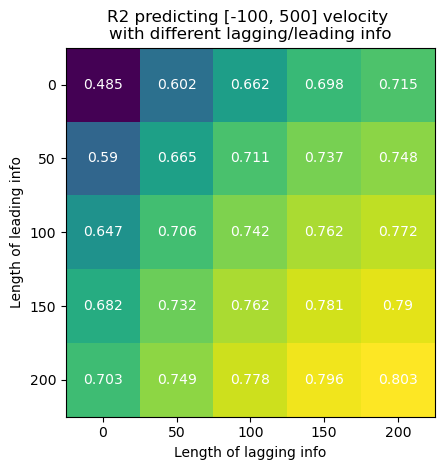

In [33]:
fig, ax = plt.subplots()
im = ax.imshow(PCA_whole_multi_R2s)
ax.set_xlabel('Length of lagging info')
ax.set_ylabel('Length of leading info')

ax.set_xticks(np.arange(len(t_after_range)))
ax.set_yticks(np.arange(len(t_before_range)))
ax.set_xticklabels(labels=t_after_range)
ax.set_yticklabels(labels=t_before_range)

ax.set_title("R2 predicting [-100, 500] velocity \nwith different lagging/leading info")
fig.tight_layout()

for i in range(len(t_before_range)):
    for j in range(len(t_after_range)):
        text = ax.text(j, i, str(int(PCA_whole_multi_R2s[i, j]*1000)/1000),
                       ha="center", va="center", color="w")
plt.show()

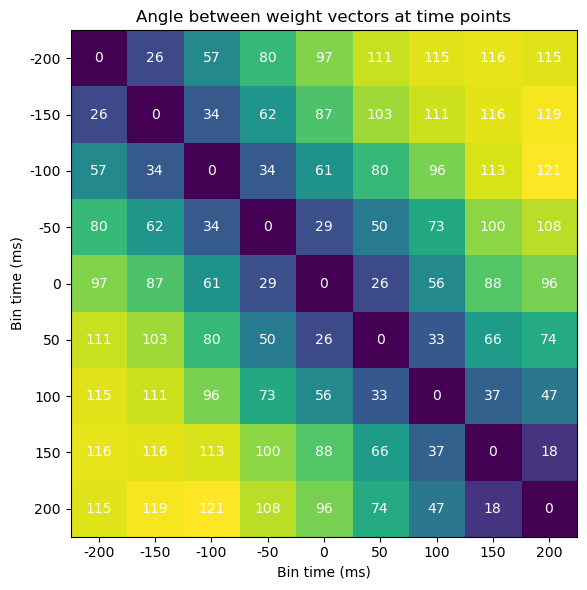

In [35]:
coef_X = PCA_whole_multi_coefs[-1][-1][0] #which entry's weights to use

t_label = np.arange(-200,201,50)

n_weights = len(t_before_range) + len(t_after_range) - 1
coef_X_reshaped = coef_X.reshape(n_weights,n_dims)
angDist_array = nans([n_weights,n_weights])
for i in range(n_weights):
    for j in range(n_weights):
        angDist_array[i,j] = math.degrees(angle_between(coef_X_reshaped[i,:],coef_X_reshaped[j,:]))
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(angDist_array)
ax.set_xlabel('Bin time (ms)')
ax.set_ylabel('Bin time (ms)')

ax.set_xticks(np.arange(len(t_label)))
ax.set_yticks(np.arange(len(t_label)))
ax.set_xticklabels(labels=t_label)
ax.set_yticklabels(labels=t_label)

ax.set_title("Angle between weight vectors at time points")
fig.tight_layout()

for i in range(len(t_label)):
    for j in range(len(t_label)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                       ha="center", va="center", color="w")
plt.show()
